In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))

import geopandas as gpd
from laos_gggi.plotting import configure_plot_style, prepare_gridspec_figure
from laos_gggi.data_functions.combine_data import load_all_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az

import pymc as pm
import pytensor.tensor as pt
from pymc_extras.statespace import BayesianETS
from pymc_extras.statespace.utils.data_tools import ImputationWarning
from functools import partial
import preliz as pz

import warnings
warnings.filterwarnings(action='ignore', 
                        message='Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering',
                        category=ImputationWarning)
warnings.filterwarnings(action='ignore', message='compile_pymc was renamed to compile', category=FutureWarning)
warnings.filterwarnings(action='ignore', message='Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it',
                        category=UserWarning)
warnings.filterwarnings(action='ignore', message='The RandomType SharedVariables',
                        category=UserWarning)
configure_plot_style(add_grid=True)

In [3]:
from sklearn.preprocessing import StandardScaler

data = load_all_data()
df_raw = data['df_time_series']
df_laos = data["df_panel"].loc["LAO"][["gdp_per_cap", "Population", "population_density",] ]

df_merged = pd.merge(df_laos, df_raw, left_index=True, right_index= True, how = "right")

#scale values
scaler = StandardScaler()
scaler.set_output(transform='pandas')
df = scaler.fit_transform(df_merged)

In [4]:
mod = BayesianETS(order=('A', 'Ad', 'N'), 
                   endog_names=df.columns, 
                   stationary_initialization=True,
                   dense_innovation_covariance=True,
                   measurement_error=True,
                   initialization_dampening=0.95)

The following parameters should be assigned priors inside a PyMC model block: 
	initial_level -- shape: (6,), constraints: None, dims: ('observed_state',)
	initial_trend -- shape: (6,), constraints: None, dims: ('observed_state',)
	alpha -- shape: (6,), constraints: 0 < alpha < 1, dims: ('observed_state',)
	beta -- shape: (6,), constraints: 0 < beta < 1, dims: ('observed_state',)
	phi -- shape: (6,), constraints: 0 < phi < 1, dims: ('observed_state',)
	state_cov -- shape: (6, 6), constraints: Positive Semi-definite, dims: ('observed_state', 'observed_state_aux')
	sigma_obs -- shape: (6,), constraints: Positive, dims: ('observed_state',)


In [5]:
maxent = partial(pz.maxent, plot=False)

priors = {
    'initial_level':maxent(pz.Normal(), lower=-2.0, upper=2.0),
    'initial_trend':maxent(pz.Normal(), lower=-0.5, upper=0.5),
    'alpha':maxent(pz.Beta(), lower=0.8, upper=0.99),
    'beta':maxent(pz.Beta(), lower=0.8, upper=0.99),
    'phi':maxent(pz.Beta(), lower=0.8, upper=0.99),
    'sigma_obs': maxent(pz.Gamma(), lower=0.01, upper=0.1)
}

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\numba\np\ufunc\dufunc.py:287: RuntimeWarning: invalid value encountered in nb_logpdf
  return super().__call__(*args, **kws)


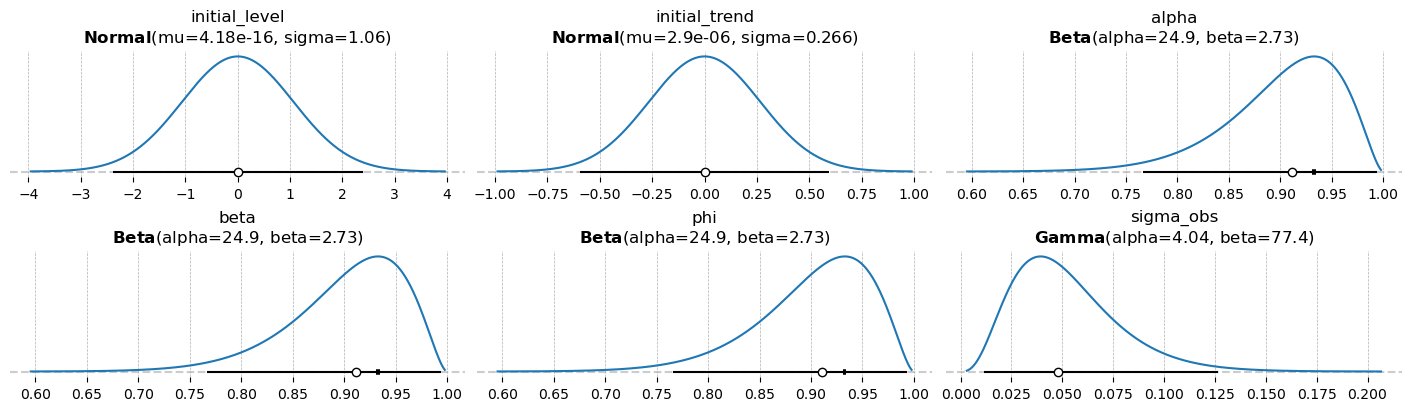

In [6]:
fig = plt.figure(layout='constrained')
gs, locs = prepare_gridspec_figure(n_cols=3, n_plots=len(priors), figure=fig)
for loc, (name, dist) in zip(locs, priors.items()):
    axis = fig.add_subplot(gs[loc])
    dist.plot_pdf(ax=axis, legend='title', pointinterval=True, levels=[0.025, 0.975])
    dist_text = axis.get_title()
    axis.set_title(name + '\n' + dist_text)

In [7]:
import xarray as xr
from itertools import combinations_with_replacement

tril_cov_labels = list(combinations_with_replacement(mod.shock_names, 2))
coords = mod.coords
coords['shock_tril'] = range(len(tril_cov_labels))

shock_tril_idx = xr.Coordinates.from_pandas_multiindex(pd.MultiIndex.from_tuples(tril_cov_labels, names=['shock', 'shock_aux']), 'shock_tril')

In [8]:
sd_dist = maxent(pz.Gamma(), lower=0.01, upper=0.1).to_pymc()

with pm.Model(coords=coords) as climate_model:
    for name, dist in priors.items():
        dist.to_pymc(name=name, dims=('observed_state', ))
    state_cov_chol, *_ = pm.LKJCholeskyCov('state_cov_chol', n=6, eta=4, sd_dist=sd_dist, dims=['shock_tril'])
    state_cov = pm.Deterministic('state_cov', state_cov_chol @ state_cov_chol.T, dims=['shock', 'shock_aux'])
    mod.build_statespace_graph(df, mode='JAX')
    
    idata = pm.sample(nuts_sampler='nutpie', 
                      nuts_sampler_kwargs={'backend':'jax', 'gradient_backend':'jax'},
                      chains=6,
                      draws=500,
                      target_accept=0.95)
idata = idata.assign_coords(shock_tril_idx)


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pymc_extras\statespace\utils\data_tools.py:97: UserWarning: No frequency was specific on the data's DateTimeIndex.
  warnings.warn(NO_FREQ_INFO_WARNING)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.07,127
,1500,0,0.07,63
,1500,0,0.08,63
,1500,0,0.08,63
,1500,0,0.09,127
,1500,0,0.09,191


In [9]:
var_names = [rv.name for rv in climate_model.free_RVs]
az.summary(idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
initial_level[gdp_per_cap],-0.113,0.998,-1.952,1.687,0.013,0.020,5657.0,2145.0,1.00
initial_level[Population],-1.246,0.342,-1.863,-0.597,0.030,0.021,129.0,228.0,1.05
initial_level[population_density],-1.275,0.354,-1.889,-0.570,0.031,0.022,123.0,229.0,1.05
initial_level[co2],-1.001,0.599,-2.135,0.137,0.012,0.009,2474.0,1973.0,1.00
initial_level[Temp],-0.461,0.700,-1.776,0.835,0.010,0.011,4702.0,1938.0,1.00
initial_level[precip],-0.075,0.979,-2.087,1.607,0.013,0.017,5385.0,2538.0,1.00
initial_trend[gdp_per_cap],-0.071,0.176,-0.417,0.245,0.003,0.003,4366.0,2191.0,1.00
initial_trend[Population],0.046,0.019,0.013,0.085,0.002,0.001,130.0,255.0,1.04
initial_trend[population_density],0.047,0.020,0.011,0.086,0.002,0.001,123.0,261.0,1.04
initial_trend[co2],0.054,0.042,-0.029,0.131,0.001,0.001,2470.0,2073.0,1.00


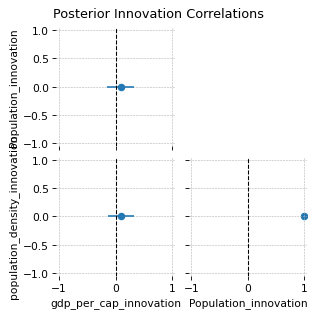

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4), dpi=77, sharex=True, sharey=True, subplot_kw={'aspect':'equal'})
ax[0, 1].set(xlim=(-1.05, 1.05), ylim=(-1.05, 1.05), visible=False)
for i,j in [(1, 0), (2, 0), (2, 1)]:
    axis = ax[i-1, j]
    if j == 0:
        axis.set_ylabel(mod.shock_names[i])
    if i == 2:
        axis.set_xlabel(mod.shock_names[j])
    plot_data =idata.posterior.state_cov_chol_corr.isel(state_cov_chol_corr_dim_0=i, state_cov_chol_corr_dim_1=j)
    hdi = az.hdi(plot_data)['state_cov_chol_corr']
    axis.scatter(plot_data.mean(dim=['chain', 'draw']), 0)
    axis.hlines(0, *hdi.values.T)
    axis.axvline(0, ls='--', lw=1, c='k')
fig.suptitle('Posterior Innovation Correlations')
plt.show()

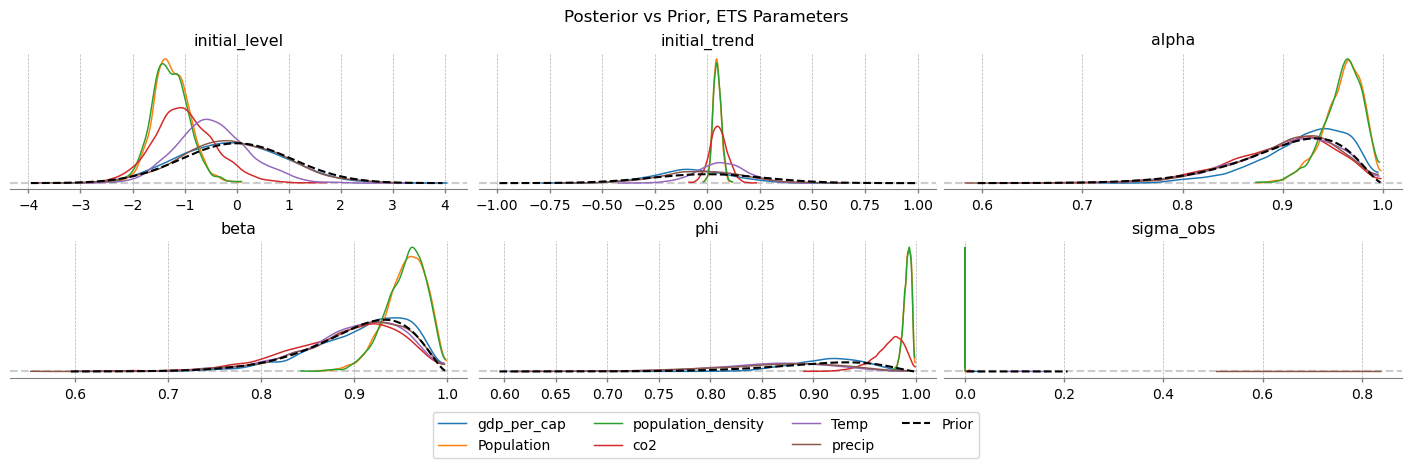

In [11]:
fig = plt.figure(figsize=(14, 4))
gs, locs = prepare_gridspec_figure(n_cols=3, n_plots=len(var_names) - 1, figure=fig)

for name, loc in zip(var_names[:-1], locs):
    axis = fig.add_subplot(gs[loc])
    for i, coord in enumerate(
        mod.observed_states):
        color = plt.color_sequences['tab10'][i]
        az.plot_posterior(idata, var_names=[name], ax=axis, point_estimate=None, hdi_prob='hide', coords={'observed_state':coord}, color=color, textsize=10)
    handles = axis.get_lines()
    [handle.set_label(coord) for coord, handle in zip(mod.observed_states, handles)]
    
    priors[name].plot_pdf(ax=axis, legend=False, color='k')
    prior_kde = axis.get_lines()[-1]
    prior_kde.set_linestyle('--')
    prior_kde.set_label('Prior')
    
    handles.append(prior_kde)
    
fig.legend(handles=handles, ncols=4, bbox_to_anchor=(0.5, 0), loc='upper center')
fig.suptitle('Posterior vs Prior, ETS Parameters')
plt.show()

In [12]:
cond_post = mod.sample_conditional_posterior(idata)

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

In [13]:
forecast = mod.forecast(idata, periods=100)

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]


Output()

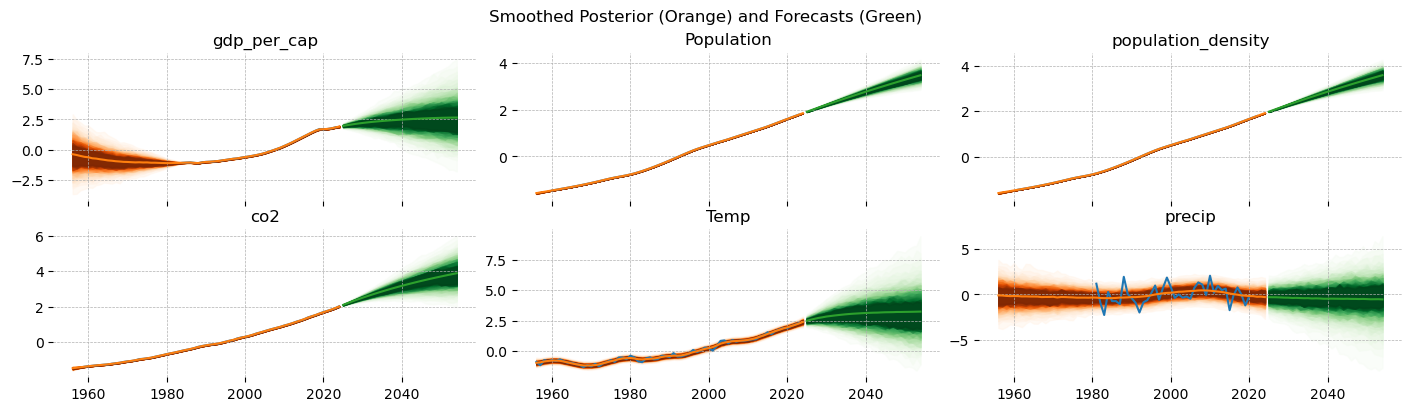

In [14]:
fig, ax = plt.subplots(2, 3, sharex=True)
group = 'smoothed'
x_grid = df.index
x_grid_forecast = forecast['time'].values

h = 30

plot_data = cond_post[f'{group}_posterior_observed']
forecast_data = forecast['forecast_observed']

mu = plot_data.mean(dim=['chain', 'draw'])
mu_forecast = forecast_data.mean(dim=['chain', 'draw'])
hdi_probs = np.linspace(51, 99, 40)
hdi = {x: az.hdi(plot_data, hdi_prob=x / 100)[f'{group}_posterior_observed'] for x in hdi_probs}
hdi_forecast = {x: az.hdi(forecast_data, hdi_prob = x / 100)['forecast_observed'] for x in hdi_probs}

for axis, name in zip(fig.axes, mod.observed_states):
    axis.plot(x_grid, df[name])
    axis.plot(x_grid, mu.sel(observed_state=name))
    axis.plot(x_grid_forecast[:h], mu_forecast.sel(observed_state=name).isel(time=slice(None, h)))
    
    colors = (hdi_probs - np.min(hdi_probs)) / (np.max(hdi_probs) - np.min(hdi_probs))
    cmap_interp = plt.get_cmap('Oranges')
    cmap_forecast = plt.get_cmap('Greens')
    
    for i, x in enumerate(hdi_probs[::-1]):
        color_val = colors[i]
        axis.fill_between(x_grid, *hdi[x].sel(observed_state=name).values.T, color=cmap_interp(color_val), alpha=0.6)
        axis.fill_between(x_grid_forecast[:h], *hdi_forecast[x].sel(observed_state=name).isel(time=slice(None, h)).values.T, color=cmap_forecast(color_val), alpha=0.6)
        
    axis.set_title(name)
fig.suptitle('Smoothed Posterior (Orange) and Forecasts (Green)')
plt.show()

In [15]:
smooth_df = mu.to_dataframe().unstack('observed_state').droplevel(axis=1, level=0)
forecast_df = mu_forecast.to_dataframe().unstack('observed_state').droplevel(axis=1, level=0)
res_df = pd.concat([smooth_df, forecast_df])
res_df.loc[:, :] = scaler.inverse_transform(res_df)
# forecast_df.to_csv(here('data/climate_forecast.csv'))

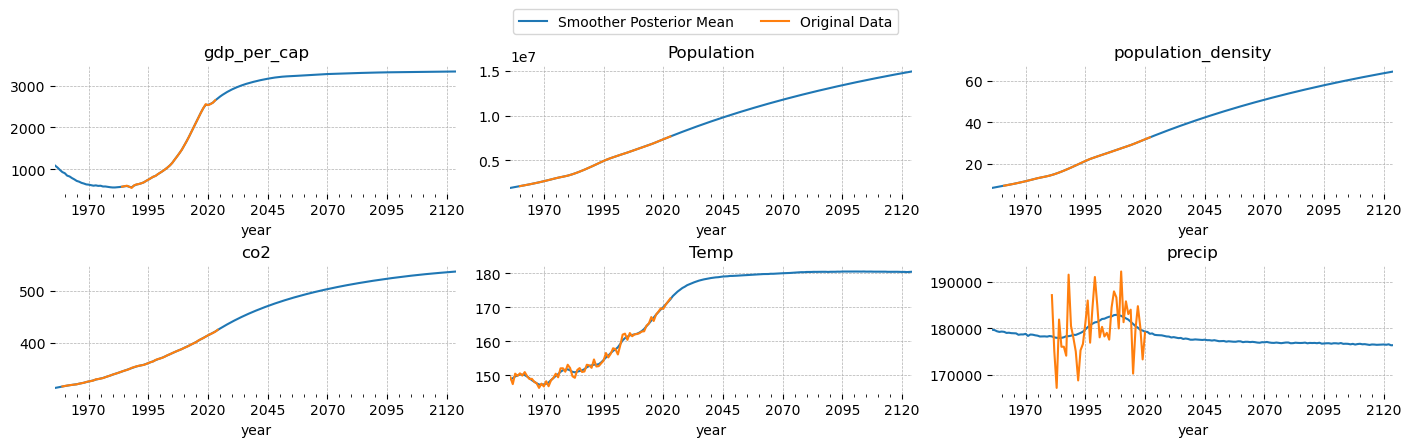

In [16]:
fig, ax = plt.subplots(2,3)
for axis, name in zip(fig.axes, mod.observed_states):
    res_df[name].plot(ax=axis, label='Smoother Posterior Mean')
    df_merged[name].plot(ax=axis, label='Original Data')
    handles = axis.get_lines()
    axis.set_title(name)
fig.legend(handles=handles, ncol=3, bbox_to_anchor=(0.5, 1.0), loc='lower center')
plt.show()

In [17]:
res_df.to_csv(here('data/climate_forecast.csv'))